# CS579 - Online Social Network Analysis

## Project - 1 Social Media Data Analysis

### Team Members:
#### Akshat Behera - A20516439
#### Rushikesh Kadam - A20517258

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

### Package Imports

In [186]:
import praw
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import re

### Initializing Reddit API Client with Credentials from JSON File

In [187]:
# This function will load credentials from a JSON file
def load_credentials(path):
    with open(path, 'r') as file:
        return json.load(file)

#THis function will initialize the Reddit API client
def initialize_reddit(credentials):
    #get credentials by using get() 
    client_id = credentials.get('client_id')
    client_secret = credentials.get('client_secret')
    user_agent = credentials.get('user_agent')
    
    return praw.Reddit(client_id=client_id,
                       client_secret=client_secret,
                       user_agent=user_agent)

file_name = 'credentials.json'
credentials = load_credentials(file_name)#load credentials
reddit = initialize_reddit(credentials)#initialize credentials

print("Reddit API Intialized Successfully")

Reddit API Intialized Successfully


### Global Variable Declaration

In [188]:
#defining variables to store nodes, edges and related data
raw_data = []
nodes = set()
edges = []

### User Input: Set Limit and Subreddit Name

In [189]:
subreddit_name1 = input("Enter the subreddit name from which you want to extract the data: ")

Enter the subreddit name from which you want to extract the data: dataengineering


In [190]:
limit1 = int(input("Enter the limit to extract number of Submissions: "))

Enter the limit to extract number of Submissions: 6


### Data Extraction

In [191]:
import praw
# this function will extract the data from Reddit API
def extract_data(subreddit_name, limit):
    subreddit = reddit.subreddit(subreddit_name) #Accessing the subreddit with the given name
    submissions = subreddit.top(limit=limit) # Selecting top submissions with the given limit
    
    for submission in submissions:
        if submission.author:
            author = submission.author.name #setting the name of an author to the attribute
        else:
            author = "Unknown"# if there is no name of an author then setting it as unknown 
        nodes.add(author)
        
        comment_count = 0  #counting comments for limiting the extraction
        
        #this loop will add name of the commenter in nodes who has commented on a post posted by an author
        #Also this loop will append the list of edges with the pair of author and commenter
        for comment in submission.comments.list():
            if(comment_count < 120):
                if hasattr(comment, 'author') and comment.author:
                    commenter = comment.author.name #getting name of the author who has commented 
                    nodes.add(commenter)
                    edges.append((author, commenter))
                    comment_count = comment_count + 1 #increasing the comment count by one after getting data for comment
     
    #this loop will append edges in raw_data
    for edge in edges:
        raw_data.append({'source': edge[0], 'target': edge[1]})
    
    return nodes, edges, raw_data


#calling Extract_data() to get edges, nodes and raw data with required limit and subreddit name
nodes, edges, raw_data = extract_data(subreddit_name1, limit1)

print("Successfully extracted data from Reddit.")

Successfully extracted data from Reddit.


### Node Vs Edges

Number of Nodes: 352
Number of Edges: 478


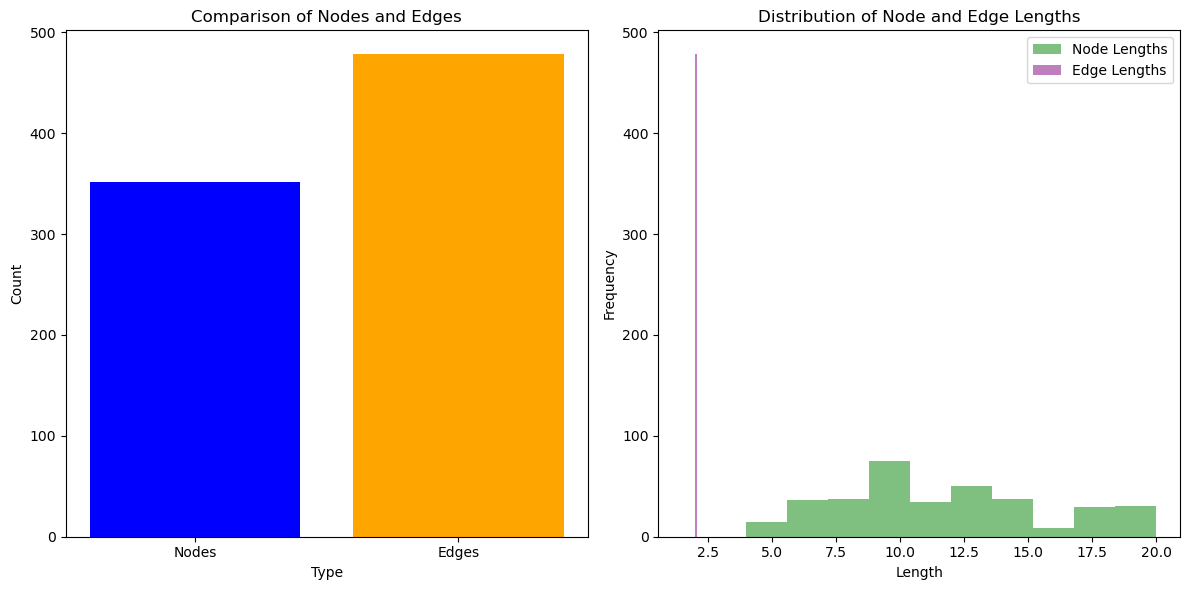

In [192]:
#printing number of nodes and edges
print("Number of Nodes:", len(nodes))
print("Number of Edges:", len(edges))

#representing comparison between number of nodes and edges by using graph

plt.figure(figsize=(12, 6))

#plotting bar graph for comparing number of nodes and edges
plt.subplot(1, 2, 1)
plt.bar(['Nodes', 'Edges'], [len(nodes), len(edges)], color=['blue', 'orange'])
plt.title('Comparison of Nodes and Edges')
plt.xlabel('Type')
plt.ylabel('Count')

# Plotting Histogram for distribution of lengths of nodes and edges
plt.subplot(1, 2, 2)
plt.hist([len(node) for node in nodes], color='green', alpha=0.5, label='Node Lengths')
plt.hist([len(edge) for edge in edges], color='purple', alpha=0.5, label='Edge Lengths')
plt.title('Distribution of Node and Edge Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

### Data Cleaning

In [193]:
#removing any self loops

filtered_edges = []

for edge in edges:
    # Check if the source node is not equal to the target node
    if edge[0] != edge[1]:
        # If the edge does not form a self-loop, append it to the filtered_edges list
        filtered_edges.append(edge)
edges = filtered_edges    

In [194]:
#removing duplicate edges
unique_edges = []
for edge in edges:
    sorted_edge = tuple(sorted(edge))
    
    if sorted_edge not in unique_edges:
        unique_edges.append(sorted_edge)


In [195]:
#removing edges with missing or None values
clean_edges = []
for edge in unique_edges:
    if None not in edge and "" not in edge:
        clean_edges.append(edge)

In [196]:
#filtering out irrelevant or noisy data (removing edges with usernames containing special characters)
filtered_clean_edges = []

for edge in clean_edges:
    if all(c.isalnum() or c in ['_', '-'] for c in edge):
        filtered_clean_edges.append(edge)
        
# Update the 'clean_edges' list with the filtered clean edges
clean_edges = filtered_clean_edges

In [197]:
#removing edges with usernames that are too short or too long(Here we are considering legth between 3 and 20)

filtered_clean_edges = []

for edge in clean_edges:
    if 3 <= len(edge[0]) <= 20 and 3 <= len(edge[1]) <= 20:
        filtered_clean_edges.append(edge)
        
clean_edges = filtered_clean_edges


In [198]:
#removing edges with usernames containing non-ASCII characters

filtered_clean_edges = []

for edge in clean_edges:
    if all(ord(c) < 128 for c in edge[0]) and all(ord(c) < 128 for c in edge[1]):
        filtered_clean_edges.append(edge)

clean_edges = filtered_clean_edges

In [199]:
#removing edges with usernames containing consecutive underscores or hyphens

filtered_clean_edges = []

for edge in clean_edges:
    if not re.search(r'[-_]{2,}', edge[0]) and not re.search(r'[-_]{2,}', edge[1]):
        filtered_clean_edges.append(edge)

clean_edges = filtered_clean_edges

In [200]:
#storing all cleaned edges in clean data

clean_data = [{'source': edge[0], 'target': edge[1]} for edge in clean_edges]

print("Data cleaning completed successfully!!!")

Data cleaning completed successfully!!!


### Exporting extracted data to CSV File

In [201]:
#this function will save extracted data to CSV files according to the type of data
def save_data_to_csv(data, file_name):
    
    #if the given data is in list it will convert that list into dataframe
    if isinstance(data, list):
        data = pd.DataFrame(data)
        
    data.to_csv(file_name, index=False)#saving in CSV file
    print("Successfully saved data Dto CSV:", file_name)

#saving raw_data and clean_edges to CSV files
save_data_to_csv(raw_data, 'raw_data.csv')
save_data_to_csv(clean_edges, 'clean_data.csv')


#saving nodes data to CSV file
# generating list of unique ids for nodes
node_ids = range(len(nodes))
# Creating dataframe with id and node for storing nodes data
nodes_df = pd.DataFrame({'ID': node_ids, 'node': list(nodes)})
#saving data to csv
save_data_to_csv(nodes_df, 'nodes.csv')

#saving edges data to CSV file
#creating dataframe with 'source' and 'target' columns for edges
edges_df = pd.DataFrame({'source': [edge[0] for edge in edges], 'target': [edge[1] for edge in edges]})
#saving edges data to CSV file
save_data_to_csv(edges_df, 'edges.csv')



Successfully saved data Dto CSV: raw_data.csv
Successfully saved data Dto CSV: clean_data.csv
Successfully saved data Dto CSV: nodes.csv
Successfully saved data Dto CSV: edges.csv


### Visualization of Network Graph

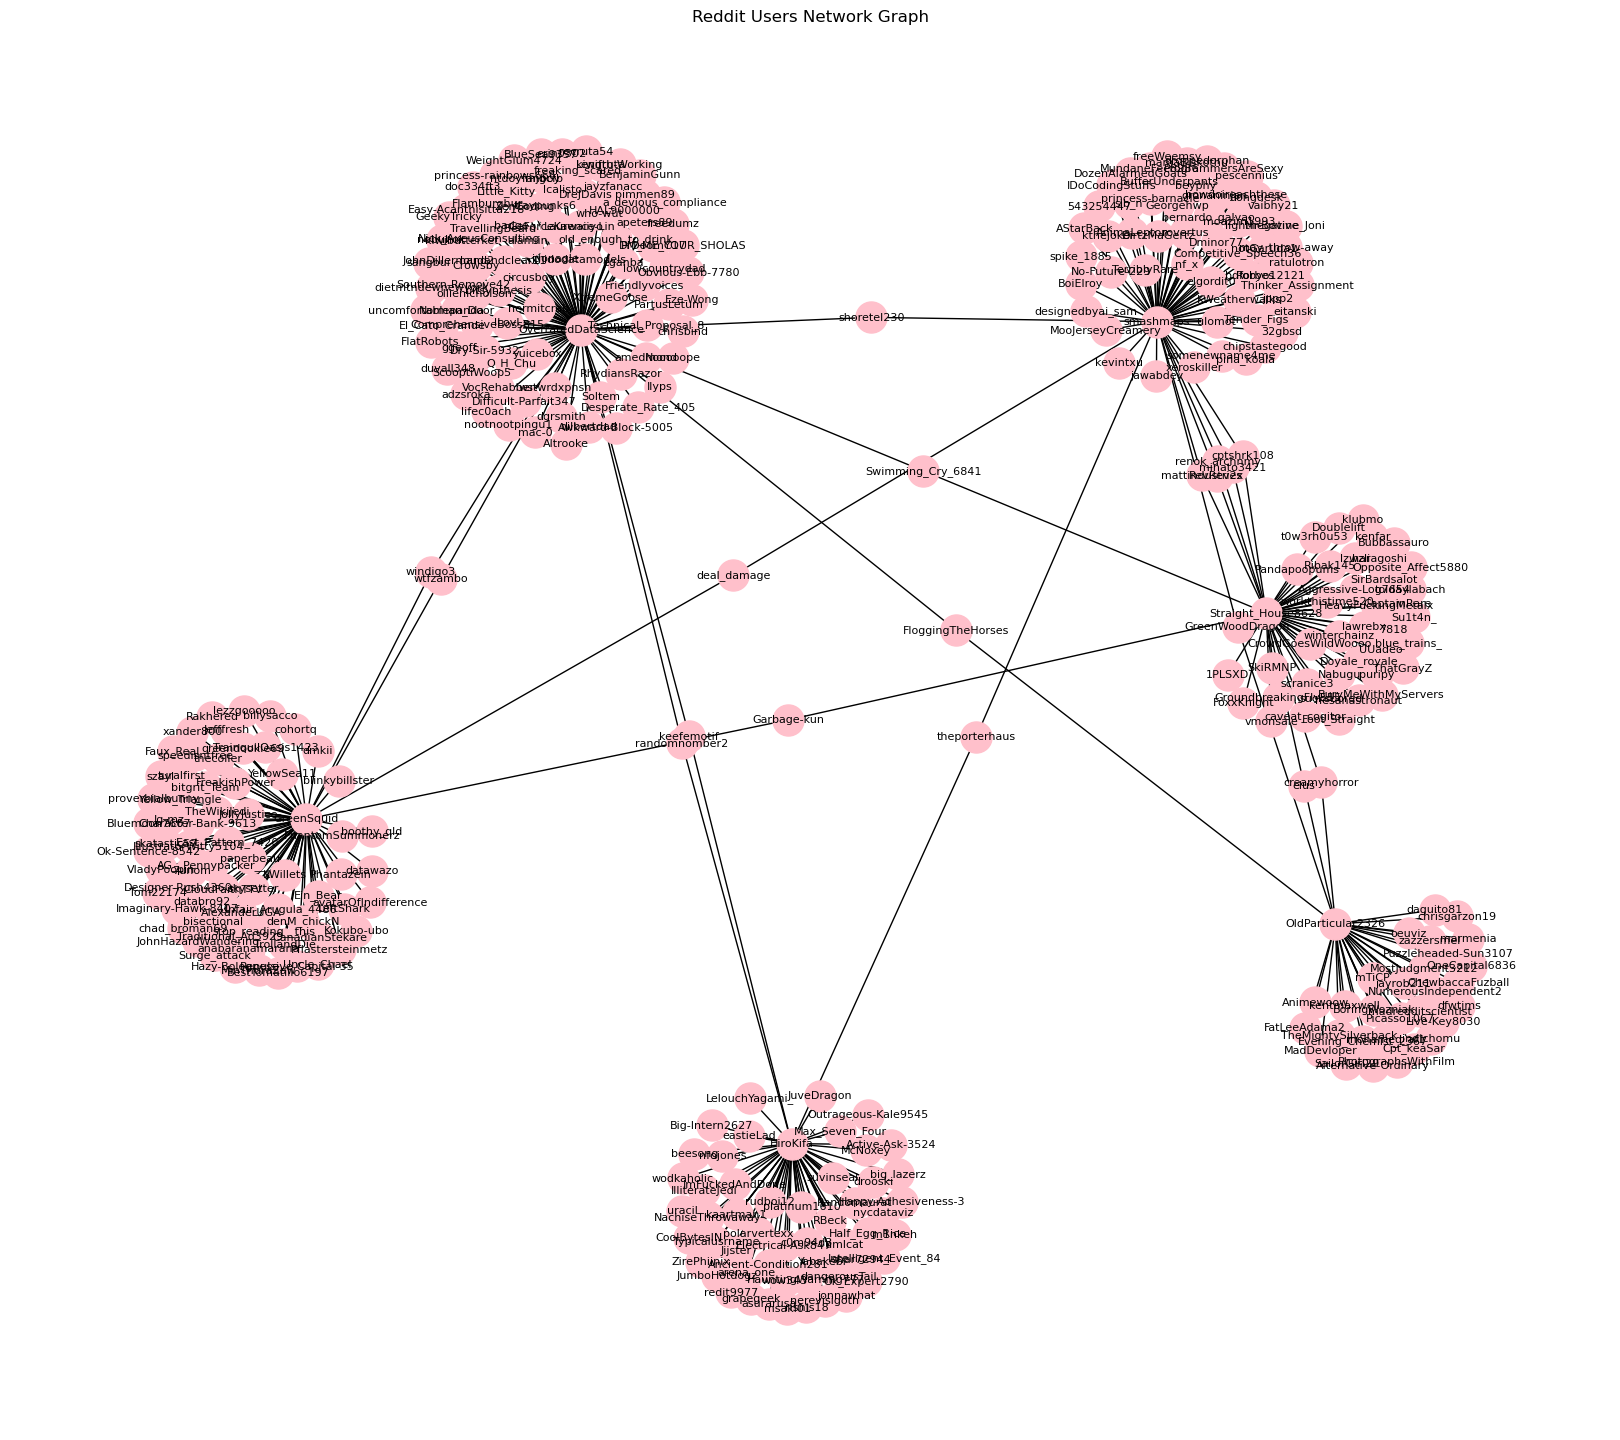

Reddit Users Network graph visualized Successfully!


In [202]:
#this function will visualize the network graph by using cleaned nodes and edges data
def visualize_network_graph(nodes, edges):
    G = nx.Graph()
    
    #adding nodes and edged to the graph
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    plt.figure(figsize=(16, 14))
    
    #drawing the graph
    nx.draw(G, with_labels=True, node_color='pink', node_size=500, edge_color='black', linewidths=1, font_size=8)
    
    plt.title('Reddit Users Network Graph')
    plt.show()
    print("Reddit Users Network graph visualized Successfully!")

# Visualize the network graph
visualize_network_graph(nodes, edges)


In [203]:
#creating a graph and adding nodes and edges for calculating further attributes

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

### Degree Centrality

In [204]:
#calculating degree centrality
degree_centrality = nx.degree_centrality(G)

#converting degree centrality to DataFrame for better readability 
df = pd.DataFrame(degree_centrality.items(), columns=['Node', 'Degree Centrality'])

#calculating Degree Centrality Mean
mean_degree_centrality = df['Degree Centrality'].mean()


#printing results
print("Degree Centrality calculated:")
print(df)
print("Mean Degree Centrality:", mean_degree_centrality)

print("Degree Centrality calculated successfully!!!")

Degree Centrality calculated:
                   Node  Degree Centrality
0             ThatGrayZ           0.002849
1           MadDevloper           0.002849
2     DozenAlarmedGoats           0.002849
3              vmonsale           0.002849
4    uncomfortablepanda           0.002849
..                  ...                ...
347           apeters89           0.002849
348       chad_broman69           0.002849
349             Q_H_Chu           0.002849
350        polarvertexx           0.002849
351          hermitcrab           0.002849

[352 rows x 2 columns]
Mean Degree Centrality: 0.005892255892255898
Degree Centrality calculated successfully!!!


### Betweenness Centrality

In [205]:
#calculating betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

#converting betweenness centrality to DataFrame for better readability 
df = pd.DataFrame(betweenness_centrality.items(), columns=['Node', 'Betweenness Centrality'])

#calculating Betweenness Centrality Mean
mean_betweenness_centrality = df['Betweenness Centrality'].mean()

#printing results
print("Betweenness Centrality calculated:")
print(df)
print("Mean Betweenness Centrality:", mean_betweenness_centrality)

print("Betweenness Centrality calculated successfully!!!")


Betweenness Centrality calculated:
                   Node  Betweenness Centrality
0             ThatGrayZ                     0.0
1           MadDevloper                     0.0
2     DozenAlarmedGoats                     0.0
3              vmonsale                     0.0
4    uncomfortablepanda                     0.0
..                  ...                     ...
347           apeters89                     0.0
348       chad_broman69                     0.0
349             Q_H_Chu                     0.0
350        polarvertexx                     0.0
351          hermitcrab                     0.0

[352 rows x 2 columns]
Mean Betweenness Centrality: 0.00819985569985569
Betweenness Centrality calculated successfully!!!


### Closeness Centrality

In [206]:
#calculating closeness centrality
closeness_centrality = nx.closeness_centrality(G)

#converting closeness centrality to DataFrame for better readability 
df = pd.DataFrame(closeness_centrality.items(), columns=['Node', 'Closeness Centrality'])

#calculating Closeness Centrality Mean
mean_closeness_centrality = df['Closeness Centrality'].mean()

#printing results
print("Closeness Centrality calculated:")
print(df)
print("Mean Closeness Centrality:", mean_closeness_centrality)

print("Closeness Centrality calculated successfully!!!")

Closeness Centrality calculated:
                   Node  Closeness Centrality
0             ThatGrayZ              0.248936
1           MadDevloper              0.223282
2     DozenAlarmedGoats              0.276378
3              vmonsale              0.248936
4    uncomfortablepanda              0.290563
..                  ...                   ...
347           apeters89              0.290563
348       chad_broman69              0.246489
349             Q_H_Chu              0.290563
350        polarvertexx              0.224138
351          hermitcrab              0.290563

[352 rows x 2 columns]
Mean Closeness Centrality: 0.2615897138932656
Closeness Centrality calculated successfully!!!


### Plotting PageRank Distribution

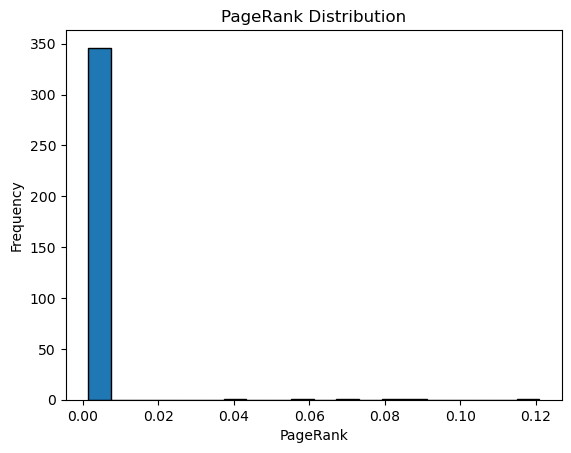

Average PageRank: 0.002840909090909106
PageRank distribution plotted successfully!


In [207]:
pagerank = nx.pagerank(G)

#plotting histogram
plt.hist(list(pagerank.values()), bins=20, edgecolor='black')

#setting title and labels
plt.title('PageRank Distribution')
plt.xlabel('PageRank')
plt.ylabel('Frequency')

#displaying the plot
plt.show()

pagerank_values = list(pagerank.values())
avg_pagerank = sum(pagerank_values) / len(pagerank_values)

print("Average PageRank:", avg_pagerank)

print("PageRank distribution plotted successfully!")

### Plotting Clustering Coefficient Distribution

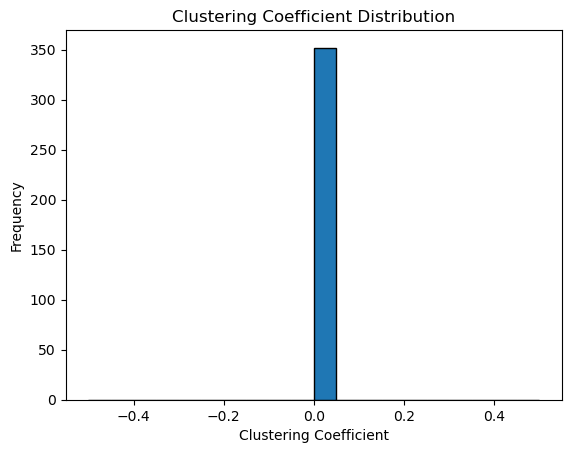

Clustering coefficient distribution plotted successfully!


In [219]:
clustering = nx.clustering(G)
clustering_values = list(clustering.values())

#calculating average clustering coefficient
avg_clustering = sum(clustering_values) / len(clustering_values)

#plotting histogram
plt.hist(list(clustering.values()), bins=20, edgecolor='black')

#setting title and labels
plt.title('Clustering Coefficient Distribution')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')

#displaying results
plt.show()

#print("Average Clustering Coefficient:", avg_clustering)

print("Clustering coefficient distribution plotted successfully!")

In [209]:
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

### Plotting In-degree Distribution

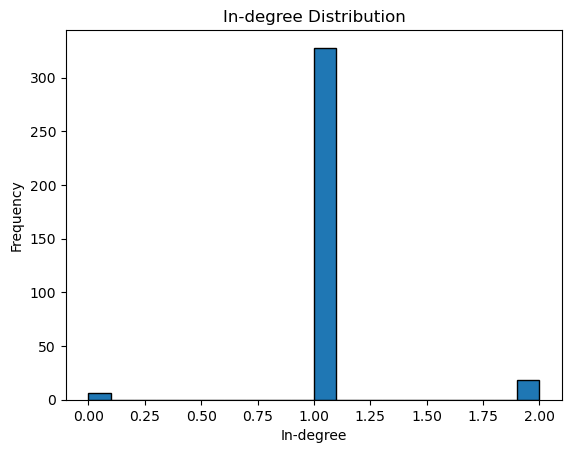

In-degree distribution plotted successfully!
Average In-degree: 1.0340909090909092


In [210]:
#calculating In-degree
indegree = dict(G.in_degree())

#plotting histogram
plt.hist(list(indegree.values()), bins=20, edgecolor='black')

#setting title and labels
plt.title('In-degree Distribution')
plt.xlabel('In-degree')
plt.ylabel('Frequency')

#displaying the plot
plt.show()
print("In-degree distribution plotted successfully!")

#calculating and printing the average in-degree
avg_indegree = sum(indegree.values()) / len(indegree)
print("Average In-degree:", avg_indegree)

### Plotting Out-degree Distribution

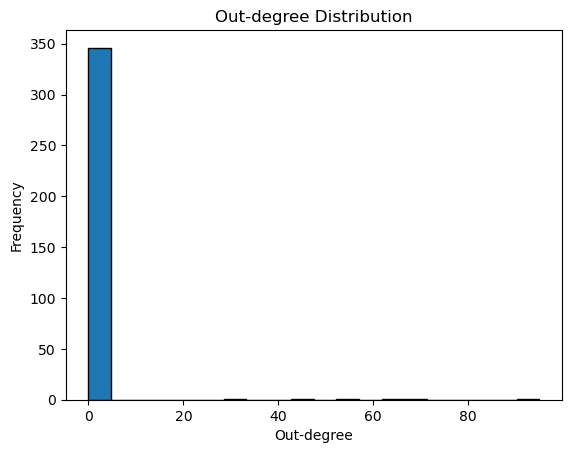

Out-degree distribution plotted successfully!
Average Out-degree: 1.0340909090909092


In [211]:
#calculating Out-degree Distribution
outdegree = dict(G.out_degree())

#plotting histogram
plt.hist(list(outdegree.values()), bins=20, edgecolor='black')

#setting title and labels
plt.title('Out-degree Distribution')
plt.xlabel('Out-degree')
plt.ylabel('Frequency')

#displaying results
plt.show()
print("Out-degree distribution plotted successfully!")

#calculating and printing the average out-degree
avg_outdegree = sum(outdegree.values()) / len(outdegree)
print("Average Out-degree:", avg_outdegree)

In [212]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

### Plotting Degree  Distribution

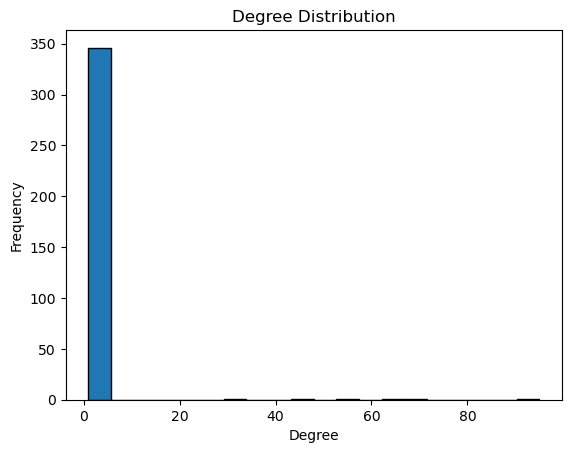

Mean Degree Distribution: 2.0681818181818183
Degree distribution plotted successfully!


In [213]:
#calculating Degree Distribution
degree_sequence = [d for n, d in G.degree()]

#calculating mean degree distribution
mean_degree = np.mean(degree_sequence)

#plotting the histogram
plt.hist(degree_sequence, bins=20, edgecolor='black')

#setting title and labels
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')

#displaying the results
plt.show()
print("Mean Degree Distribution:", mean_degree)
print("Degree distribution plotted successfully!")

### Visualiztion of Network Diameter

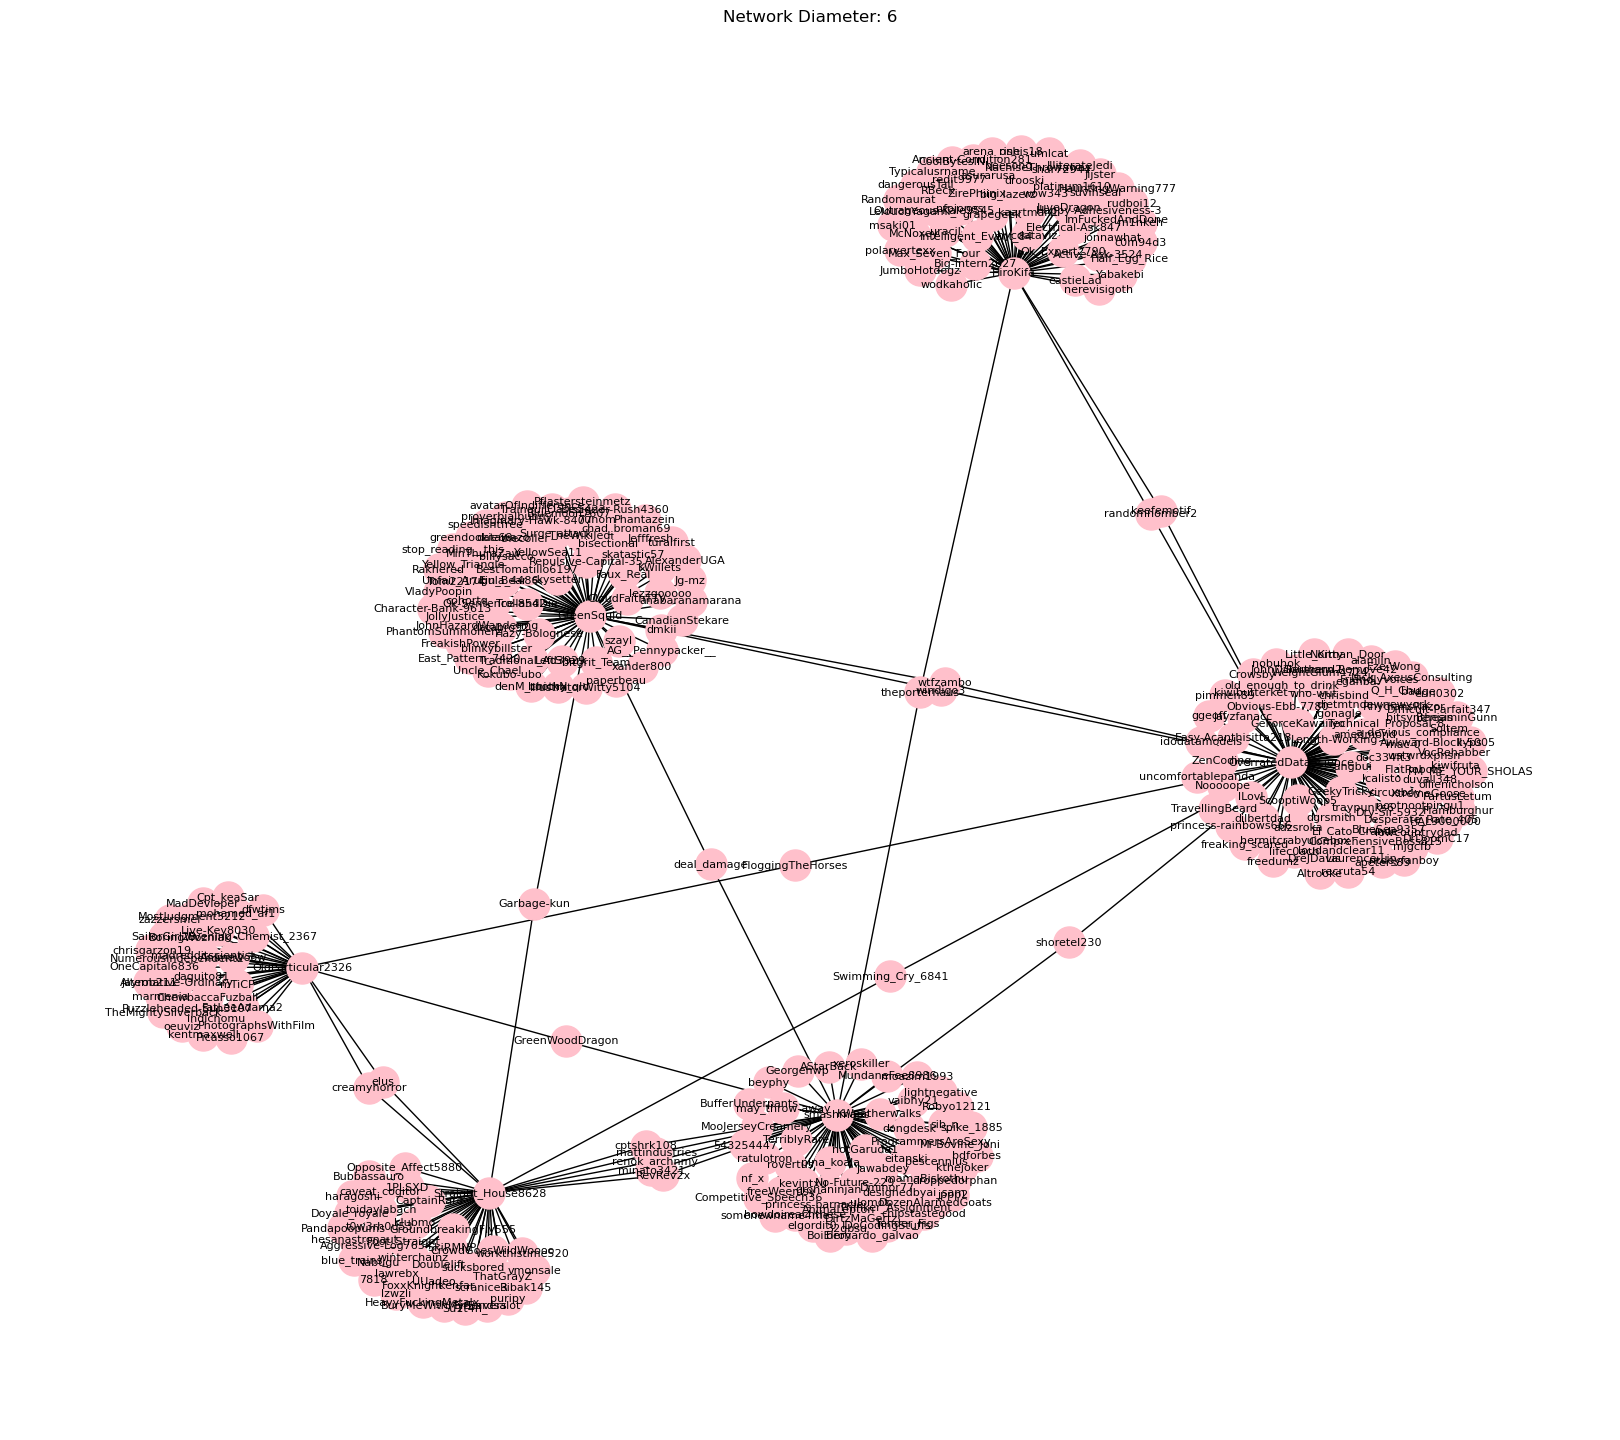

In [214]:


#calculating the network diameter
diameter = nx.diameter(G)

# Plot the network
pos = nx.spring_layout(G)  # positions for all nodes

plt.figure(figsize=(16, 14)) #setting fig size for the plot

nx.draw(G, pos, with_labels=True, node_color='pink', node_size=500, edge_color='black', linewidths=1, font_size=8)
plt.title(f'Network Diameter: {diameter}') #setting title

#displaying results
plt.show()

## Extra Network Measures

### Plotting Eigenvector Vector Centrality Distribution

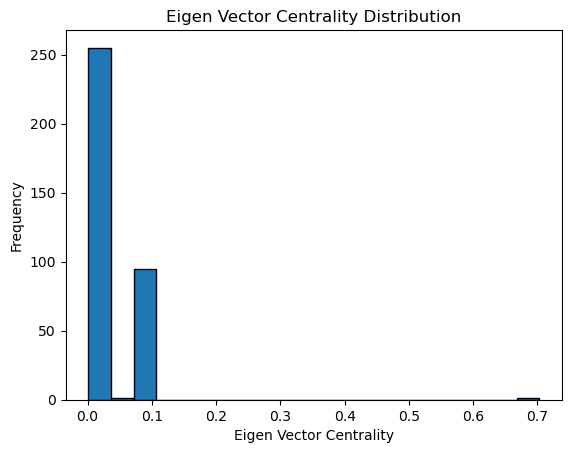

Eigen vector centrality distribution plotted successfully!
Avg. Eigen Centrality Value: 0.024519867249187956


In [215]:
#increasing the maximum number of iterations and adjusting the tolerance level for more accurate calculations
eigen_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)

#plotting histogram
plt.hist(list(eigen_centrality.values()), bins=20, edgecolor='black')

#setting title and labels
plt.title('Eigen Vector Centrality Distribution')
plt.xlabel('Eigen Vector Centrality')
plt.ylabel('Frequency')

#displaying results
plt.show()
print("Eigen vector centrality distribution plotted successfully!")


# Calculate and print the average eigen centrality
avg_eigen = sum(eigen_centrality.values()) / len(eigen_centrality)
print("Avg. Eigen Centrality Value:", avg_eigen)

### Plotting Eccentricity  Distribution

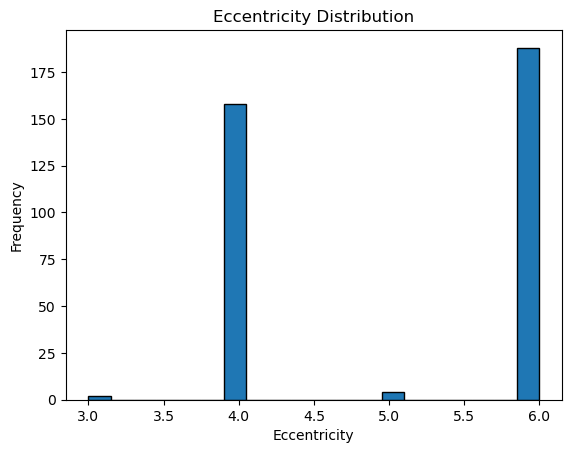

Eccentricity distribution plotted successfully!


In [216]:
#calculating Eccentricity Distribution
eccentricity = nx.eccentricity(G)

#plotiing histogram for Eccentricity Distribution
plt.hist(list(eccentricity.values()), bins=20, edgecolor='black')

#setting title and labels
plt.title('Eccentricity Distribution')
plt.xlabel('Eccentricity')
plt.ylabel('Frequency')

#displaying results
plt.show()
print("Eccentricity distribution plotted successfully!")


### Graph Density

In [217]:
#calculating and displaying Graph Density

density = nx.density(G)

print("Graph Density:", density)

Graph Density: 0.005892255892255892


### Plotting HITS Scores Distribution

C:\Users\aksha\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


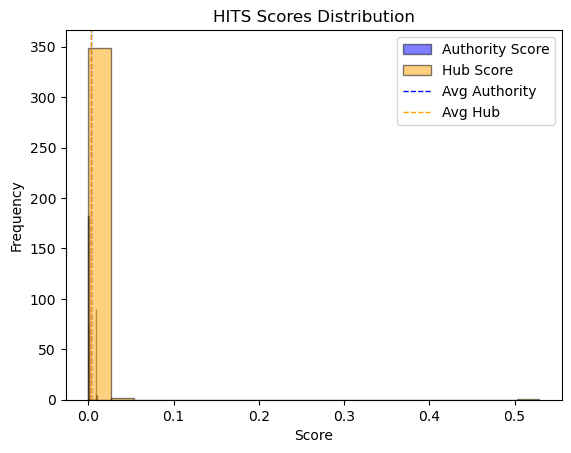

Average Authority Score: 0.0028409090909090958
Average Hub Score: 0.002840909090909095
HITS distribution plotted.


In [218]:
#calculating HITS scores for the graph 
hits = nx.hits(G)

#extracting authority and hub scores from the HITS scores
authority_scores = list(hits[0].values())
hub_scores = list(hits[1].values())

#calculating average authority and hub scores
avg_authority = sum(authority_scores) / len(authority_scores)
avg_hub = sum(hub_scores) / len(hub_scores)

#adding dashed lines representing average authority and hub scores
plt.hist(authority_scores, bins=20, color='blue', alpha=0.5, edgecolor='black', label='Authority Score')
plt.hist(hub_scores, bins=20, color='orange', alpha=0.5, edgecolor='black', label='Hub Score')

plt.axvline(x=avg_authority, color='blue', linestyle='dashed', linewidth=1, label='Avg Authority')
plt.axvline(x=avg_hub, color='orange', linestyle='dashed', linewidth=1, label='Avg Hub')

#setting title and labels for the plot
plt.title('HITS Scores Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()

#displaying the plot
plt.show()

print("Average Authority Score:", avg_authority)
print("Average Hub Score:", avg_hub)
print("HITS distribution plotted.")